In [21]:
import pandas as pd
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
from torch.nn import Linear
from torch_geometric.nn import GCNConv, GATConv, TopKPooling, global_mean_pool as gap, global_max_pool as gmp
import torch_geometric.nn
from torch_geometric.loader import DataLoader
from torch.optim import Adam
from sklearn.metrics import accuracy_score
from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.utils import add_self_loops


In [22]:
node_features = pd.read_csv('preprocessed_node_features.csv')

/var/folders/9m/5shl5b5577q1b4pkqshrp5980000gn/T/ipykernel_66568/3506719987.py:1: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,2

In [23]:
edge_features = pd.read_csv('preprocessed_edge_features.csv')

In [24]:
node_features_numeric = node_features.select_dtypes(include=['number', 'bool'])  # Include numeric and boolean columns

if 'root_id' in node_features_numeric.columns:
    node_features_numeric = node_features_numeric.drop(columns=['root_id'])



In [25]:
node_features_tensor = torch.tensor(node_features_numeric.values, dtype=torch.float)

In [26]:
id_to_index = {root_id: idx for idx, root_id in enumerate(node_features['root_id'])} # PyTorch Geometric GNN works with nodes referenced by integer indices not arbitrary IDs

edge_features['pre_root_id'] = edge_features['pre_root_id'].map(id_to_index)
edge_features['post_root_id'] = edge_features['post_root_id'].map(id_to_index)

# Remove rows with unmapped IDs
edge_features = edge_features.dropna(subset=['pre_root_id', 'post_root_id']).astype({'pre_root_id': int, 'post_root_id': int})

edge_index = torch.tensor(edge_features[['pre_root_id', 'post_root_id']].values.T, dtype=torch.long) # standard edge representation used in PyTorch Geometric


In [27]:
labels = torch.tensor(node_features['nt_type'].factorize()[0], dtype=torch.long)

In [28]:
data = Data(
    x=node_features_tensor,
    edge_index=edge_index
)

In [29]:
data.y = torch.tensor(labels, dtype=torch.long) # true labels

/var/folders/9m/5shl5b5577q1b4pkqshrp5980000gn/T/ipykernel_66568/2186120499.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data.y = torch.tensor(labels, dtype=torch.long) # true labels


In [30]:
from sklearn.model_selection import train_test_split

indices = torch.arange(len(labels)) 
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)

train_mask = torch.zeros(len(labels), dtype=torch.bool)
val_mask = torch.zeros(len(labels), dtype=torch.bool)
train_mask[train_indices] = True
val_mask[val_indices] = True

data.train_mask = train_mask
data.val_mask = val_mask

val_data = data

GCN Model

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, global_max_pool
from torch_geometric.data import DataLoader
from torch.optim import Adam

class AdvancedGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(AdvancedGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)  # Batch normalization
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.conv4 = GCNConv(hidden_dim, output_dim) 
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(self.bn1(x))
        x = self.conv2(x, edge_index)
        x = F.relu(self.bn2(x))
        x = self.conv3(x, edge_index)
        x = F.relu(self.bn3(x))
        x = self.dropout(x) 
        x = self.conv4(x, edge_index)
        
        return x

In [41]:
num_nodes = len(data.y)

indices = torch.randperm(num_nodes)

train_size = int(0.7 * num_nodes)
val_size = int(0.2 * num_nodes)
test_size = num_nodes - train_size - val_size  # Remaining for test

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Assign indices to data object
data.train_indices = train_indices
data.val_indices = val_indices
data.test_indices = test_indices


In [36]:
model = AdvancedGNN(
    input_dim=node_features_tensor.size(1),
    hidden_dim=64,
    output_dim=len(labels.unique())
)
optimizer = Adam(model.parameters(), lr=0.001) 
loss_fn = nn.CrossEntropyLoss()

In [45]:
def filter_edges_and_remap(edge_index, node_indices):
    # mapping from old node indices to new ones
    node_idx_map = {old_idx.item(): new_idx for new_idx, old_idx in enumerate(node_indices)}
    
    # Mask edges where both nodes are in node_indices
    mask = torch.isin(edge_index[0], node_indices) & torch.isin(edge_index[1], node_indices)
    filtered_edge_index = edge_index[:, mask]

    # Remap edges to the new index space
    remapped_edge_index = torch.stack([
        torch.tensor([node_idx_map[idx.item()] for idx in filtered_edge_index[0]]),
        torch.tensor([node_idx_map[idx.item()] for idx in filtered_edge_index[1]])
    ], dim=0)

    return remapped_edge_index

# Split data
train_data = data.clone()
train_data.x = data.x[train_indices]
train_data.edge_index = filter_edges_and_remap(data.edge_index, train_indices)
train_data.y = data.y[train_indices]

val_data = data.clone()
val_data.x = data.x[val_indices]
val_data.edge_index = filter_edges_and_remap(data.edge_index, val_indices)
val_data.y = data.y[val_indices]

test_data = data.clone()
test_data.x = data.x[test_indices]
test_data.edge_index = filter_edges_and_remap(data.edge_index, test_indices)
test_data.y = data.y[test_indices]

# DataLoaders
train_loader = DataLoader([train_data], batch_size=32, shuffle=True)
val_loader = DataLoader([val_data], batch_size=32, shuffle=False)
test_loader = DataLoader([test_data], batch_size=32, shuffle=False)


In [54]:
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(100):
    # Training
    model.train()
    epoch_train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        
        out = model(batch) 
        loss = loss_fn(out, batch.y)
        
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    train_losses.append(epoch_train_loss / len(train_loader))
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        correct = 0
        total = 0
        for batch in val_loader:
            out = model(batch)
            val_loss += loss_fn(out, batch.y).item()
            
            preds = out.argmax(dim=1)
            correct += (preds == batch.y).sum().item()
            total += batch.y.size(0)
        
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct / total)
    
    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

# Test 
model.eval()
with torch.no_grad():
    test_loss = 0
    correct = 0
    total = 0
    for batch in test_loader:
        out = model(batch)
        test_loss += loss_fn(out, batch.y).item()
        
        preds = out.argmax(dim=1)
        correct += (preds == batch.y).sum().item()
        total += batch.y.size(0)
    
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(correct / total)

print(f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.4f}")


Epoch 1, Train Loss: 6.6290, Val Loss: 3.3364, Val Acc: 0.5310
Epoch 2, Train Loss: 6.5909, Val Loss: 3.5951, Val Acc: 0.5115
Epoch 3, Train Loss: 6.5440, Val Loss: 3.1690, Val Acc: 0.5561
Epoch 4, Train Loss: 6.4165, Val Loss: 3.0537, Val Acc: 0.5603
Epoch 5, Train Loss: 6.6289, Val Loss: 3.9270, Val Acc: 0.6328
Epoch 6, Train Loss: 6.9654, Val Loss: 4.4075, Val Acc: 0.6281
Epoch 7, Train Loss: 7.2436, Val Loss: 4.4042, Val Acc: 0.5397
Epoch 8, Train Loss: 7.0086, Val Loss: 7.8081, Val Acc: 0.3598
Epoch 9, Train Loss: 8.6242, Val Loss: 5.6144, Val Acc: 0.6259
Epoch 10, Train Loss: 8.3987, Val Loss: 6.8542, Val Acc: 0.6351
Epoch 11, Train Loss: 9.9724, Val Loss: 7.3162, Val Acc: 0.6249
Epoch 12, Train Loss: 10.6759, Val Loss: 7.1560, Val Acc: 0.5694
Epoch 13, Train Loss: 10.7804, Val Loss: 6.8593, Val Acc: 0.4811
Epoch 14, Train Loss: 10.6970, Val Loss: 6.6115, Val Acc: 0.3936
Epoch 15, Train Loss: 10.7326, Val Loss: 8.0041, Val Acc: 0.3342
Epoch 16, Train Loss: 10.9797, Val Loss: 5.76

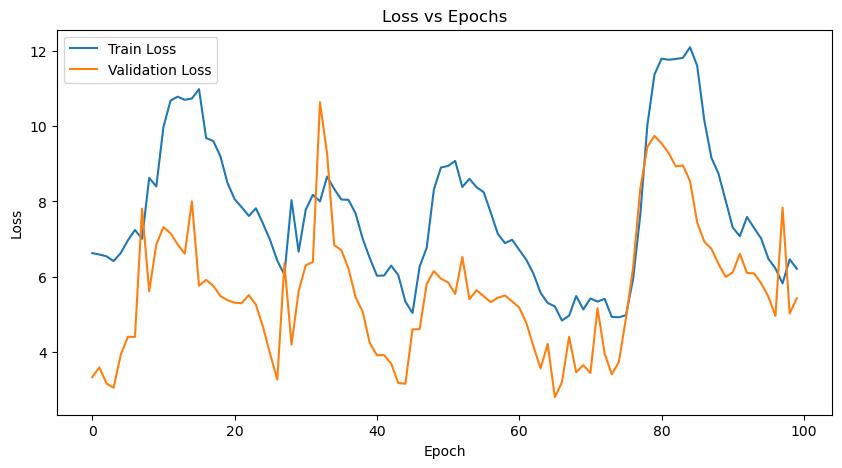

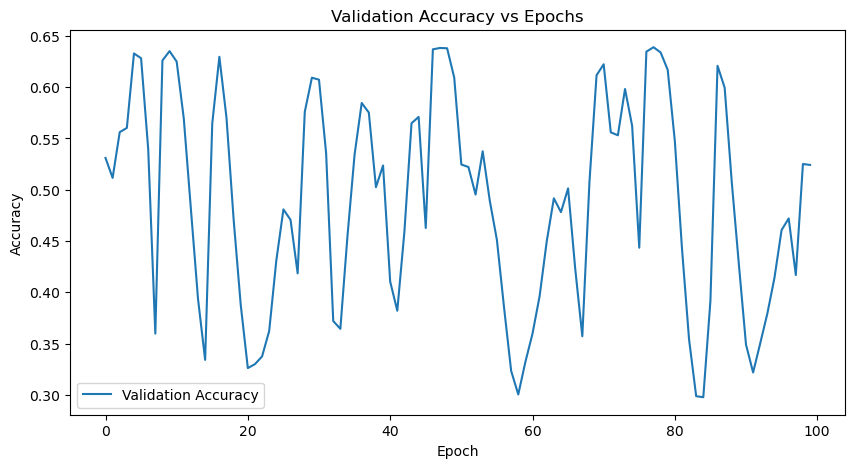

In [55]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')
plt.show()

# Plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy vs Epochs')
plt.savefig('loss_node_class_gcn.png')
plt.show()


GAT Model

In [48]:
from torch_geometric.nn import GATConv
class GATModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=8, concat=True)
        self.conv2 = GATConv(hidden_dim * 8, output_dim, heads=1, concat=False)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x


In [49]:
model = GATModel(
    input_dim=node_features_tensor.size(1),
    hidden_dim=64,
    output_dim=len(labels.unique())
)
optimizer = Adam(model.parameters(), lr=0.001) 
loss_fn = nn.CrossEntropyLoss()

In [50]:
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(100):
    # Training
    model.train()
    epoch_train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        
        out = model(batch) 
        loss = loss_fn(out, batch.y)
        
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    train_losses.append(epoch_train_loss / len(train_loader))
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        correct = 0
        total = 0
        for batch in val_loader:
            out = model(batch)
            val_loss += loss_fn(out, batch.y).item()
            
            preds = out.argmax(dim=1)
            correct += (preds == batch.y).sum().item()
            total += batch.y.size(0)
        
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct / total)
    
    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

# Test 
model.eval()
with torch.no_grad():
    test_loss = 0
    correct = 0
    total = 0
    for batch in test_loader:
        out = model(batch)
        test_loss += loss_fn(out, batch.y).item()
        
        preds = out.argmax(dim=1)
        correct += (preds == batch.y).sum().item()
        total += batch.y.size(0)
    
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(correct / total)

print(f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.4f}")


Epoch 1, Train Loss: 1490.6271, Val Loss: 401.8075, Val Acc: 0.1503
Epoch 2, Train Loss: 718.8738, Val Loss: 84.7884, Val Acc: 0.4633
Epoch 3, Train Loss: 145.2578, Val Loss: 74.8067, Val Acc: 0.5162
Epoch 4, Train Loss: 146.5951, Val Loss: 58.3682, Val Acc: 0.5429
Epoch 5, Train Loss: 57.8027, Val Loss: 50.3799, Val Acc: 0.5202
Epoch 6, Train Loss: 35.6615, Val Loss: 49.6593, Val Acc: 0.5044
Epoch 7, Train Loss: 34.7137, Val Loss: 46.7955, Val Acc: 0.5036
Epoch 8, Train Loss: 34.0568, Val Loss: 43.7180, Val Acc: 0.5071
Epoch 9, Train Loss: 32.8720, Val Loss: 35.2699, Val Acc: 0.5169
Epoch 10, Train Loss: 30.5330, Val Loss: 23.4560, Val Acc: 0.5434
Epoch 11, Train Loss: 29.0135, Val Loss: 22.3055, Val Acc: 0.5511
Epoch 12, Train Loss: 27.7711, Val Loss: 21.1926, Val Acc: 0.5146
Epoch 13, Train Loss: 26.8437, Val Loss: 20.2618, Val Acc: 0.4067
Epoch 14, Train Loss: 25.9790, Val Loss: 19.4405, Val Acc: 0.3734
Epoch 15, Train Loss: 25.0776, Val Loss: 18.4472, Val Acc: 0.3373
Epoch 16, Tra

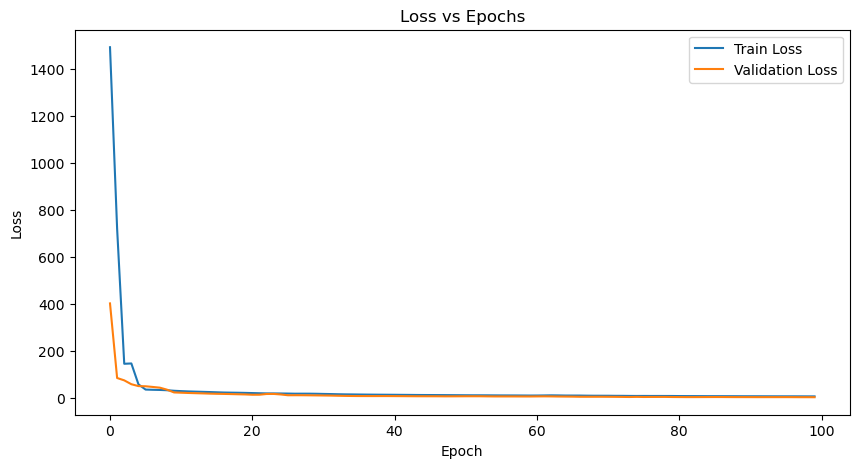

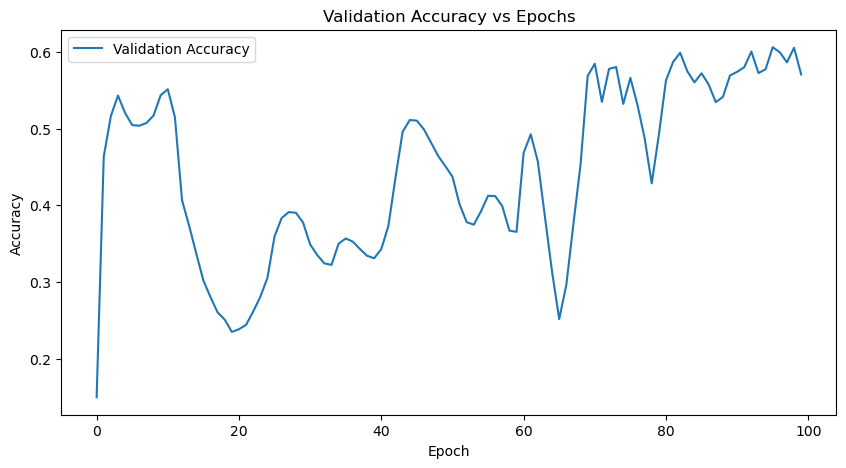

In [52]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')
plt.show()

# Plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy vs Epochs')
plt.savefig('loss_node_class_gat.png')
plt.show()


GIN Model

In [58]:
from torch_geometric.nn import GINConv
class GINModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GINModel, self).__init__()
        self.conv1 = GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.ReLU()))
        self.conv2 = GINConv(nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU()))
        self.conv3 = GINConv(nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU()))
        self.conv4 = GINConv(nn.Sequential(nn.Linear(hidden_dim, output_dim)))


    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = self.conv4(x, edge_index)
        return x

In [ ]:
model = GINModel(
    input_dim=node_features_tensor.size(1),
    hidden_dim=64,
    output_dim=len(labels.unique())
)
optimizer = Adam(model.parameters(), lr=0.001) 
loss_fn = nn.CrossEntropyLoss()

In [59]:
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(100):
    # Training
    model.train()
    epoch_train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        
        out = model(batch) 
        loss = loss_fn(out, batch.y)
        
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    train_losses.append(epoch_train_loss / len(train_loader))
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        correct = 0
        total = 0
        for batch in val_loader:
            out = model(batch)
            val_loss += loss_fn(out, batch.y).item()
            
            preds = out.argmax(dim=1)
            correct += (preds == batch.y).sum().item()
            total += batch.y.size(0)
        
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct / total)
    
    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

# Test 
model.eval()
with torch.no_grad():
    test_loss = 0
    correct = 0
    total = 0
    for batch in test_loader:
        out = model(batch)
        test_loss += loss_fn(out, batch.y).item()
        
        preds = out.argmax(dim=1)
        correct += (preds == batch.y).sum().item()
        total += batch.y.size(0)
    
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(correct / total)

print(f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.4f}")


Epoch 1, Train Loss: 7.5110, Val Loss: 8.0504, Val Acc: 0.3650
Epoch 2, Train Loss: 7.7160, Val Loss: 5.8044, Val Acc: 0.5032
Epoch 3, Train Loss: 7.4317, Val Loss: 6.0097, Val Acc: 0.5480
Epoch 4, Train Loss: 7.7464, Val Loss: 5.6318, Val Acc: 0.5499
Epoch 5, Train Loss: 7.4103, Val Loss: 5.0703, Val Acc: 0.4845
Epoch 6, Train Loss: 6.7467, Val Loss: 5.2884, Val Acc: 0.4085
Epoch 7, Train Loss: 6.3913, Val Loss: 4.9746, Val Acc: 0.4017
Epoch 8, Train Loss: 5.9818, Val Loss: 5.1532, Val Acc: 0.3539
Epoch 9, Train Loss: 5.7932, Val Loss: 5.4399, Val Acc: 0.2938
Epoch 10, Train Loss: 5.8051, Val Loss: 5.4120, Val Acc: 0.3077
Epoch 11, Train Loss: 5.8853, Val Loss: 5.2120, Val Acc: 0.3416
Epoch 12, Train Loss: 5.7225, Val Loss: 4.5905, Val Acc: 0.3704
Epoch 13, Train Loss: 5.1179, Val Loss: 3.8176, Val Acc: 0.4159
Epoch 14, Train Loss: 4.5568, Val Loss: 4.5328, Val Acc: 0.4495
Epoch 15, Train Loss: 4.7488, Val Loss: 3.2219, Val Acc: 0.5824
Epoch 16, Train Loss: 4.2332, Val Loss: 3.5314, V

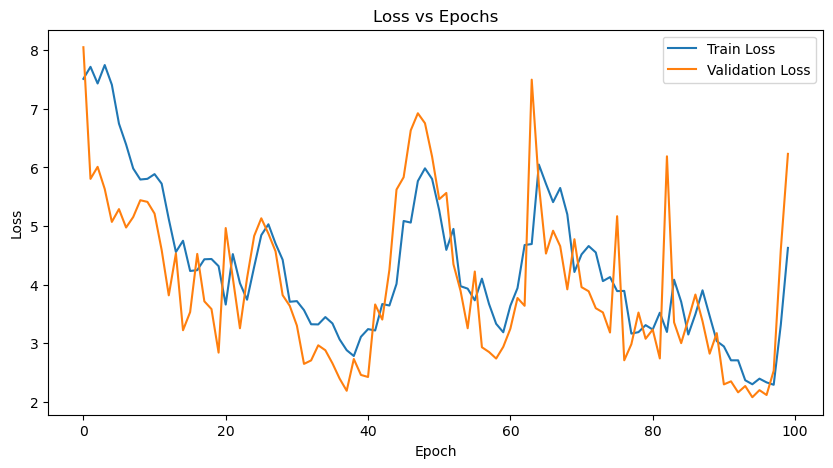

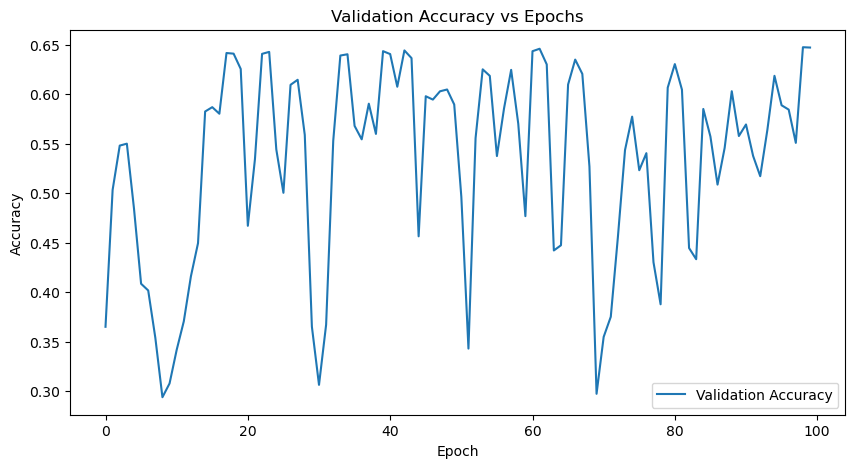

In [60]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')
plt.show()

# Plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy vs Epochs')
plt.savefig('loss_node_class_gin.png')
plt.show()
